In [ ]:
import torch
torch.cuda.is_available()
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!pip install Pillow

In [ ]:
import PIL
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/My\ Drive/journey-springfield.zip

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import random

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_train = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])          
        ])
        x = self.load_sample(self.files[index])
        # x = self._prepare_sample(x)
        # x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = transform_train(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    # def _prepare_sample(self, image):
    #     image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    #     return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, 
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

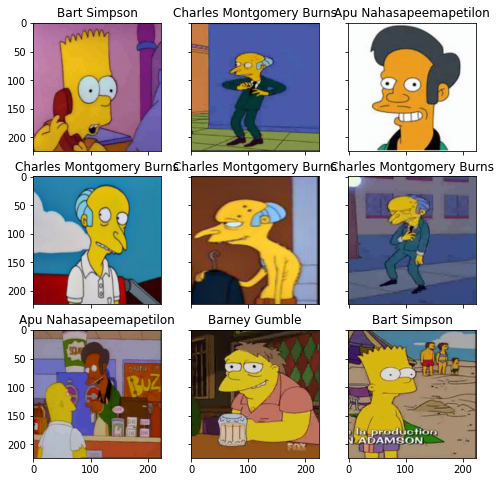

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict()
    best_acc = 0.0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(),lr=0.0001)
        criterion = nn.CrossEntropyLoss()
        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, exp_lr_scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()

            exp_lr_scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history, model.load_state_dict(best_model_wts)

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
from torchvision import models

In [ ]:
n_classes = len(np.unique(train_val_labels))
model = models.vgg16(pretrained = True).to(DEVICE)
model.classifier[6] = nn.Linear(4096,n_classes).to(DEVICE)
layers_to_unfreeze = 4
for param in model.classifier[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [ ]:
history, model_save_weights = train(train_dataset, val_dataset, model=model, epochs=24, batch_size=64)

epoch:   0%|          | 0/24 [00:00<?, ?it/s]

loss 1.8423400306270352


epoch:   4%|▍         | 1/24 [09:00<3:27:17, 540.75s/it]


Epoch 001 train_loss: 1.8423     val_loss 0.6423 train_acc 0.5128 val_acc 0.8376
loss 0.7685240717596807


epoch:   8%|▊         | 2/24 [18:00<3:18:08, 540.40s/it]


Epoch 002 train_loss: 0.7685     val_loss 0.3326 train_acc 0.8010 val_acc 0.9148
loss 0.5874662936755112


epoch:  12%|█▎        | 3/24 [26:59<3:08:58, 539.91s/it]


Epoch 003 train_loss: 0.5875     val_loss 0.3005 train_acc 0.8405 val_acc 0.9251
loss 0.526703299166359


epoch:  17%|█▋        | 4/24 [35:56<2:59:43, 539.19s/it]


Epoch 004 train_loss: 0.5267     val_loss 0.2191 train_acc 0.8618 val_acc 0.9482
loss 0.4720968997617445


epoch:  21%|██        | 5/24 [44:55<2:50:42, 539.06s/it]


Epoch 005 train_loss: 0.4721     val_loss 0.2648 train_acc 0.8730 val_acc 0.9358
loss 0.44896267712803445


epoch:  25%|██▌       | 6/24 [53:53<2:41:37, 538.77s/it]


Epoch 006 train_loss: 0.4490     val_loss 0.2086 train_acc 0.8788 val_acc 0.9534
loss 0.4060646271571224


epoch:  29%|██▉       | 7/24 [1:02:51<2:32:32, 538.40s/it]


Epoch 007 train_loss: 0.4061     val_loss 0.2088 train_acc 0.8917 val_acc 0.9522
loss 0.32172414490266


epoch:  33%|███▎      | 8/24 [1:11:48<2:23:29, 538.09s/it]


Epoch 008 train_loss: 0.3217     val_loss 0.1605 train_acc 0.9160 val_acc 0.9681
loss 0.2905899737035251


epoch:  38%|███▊      | 9/24 [1:20:45<2:14:25, 537.69s/it]


Epoch 009 train_loss: 0.2906     val_loss 0.1659 train_acc 0.9252 val_acc 0.9683
loss 0.27930142510502237


epoch:  42%|████▏     | 10/24 [1:29:42<2:05:25, 537.51s/it]


Epoch 010 train_loss: 0.2793     val_loss 0.1646 train_acc 0.9265 val_acc 0.9679
loss 0.2753775368694196


epoch:  46%|████▌     | 11/24 [1:38:40<1:56:31, 537.81s/it]


Epoch 011 train_loss: 0.2754     val_loss 0.1569 train_acc 0.9268 val_acc 0.9708
loss 0.2743813334790694


epoch:  50%|█████     | 12/24 [1:47:39<1:47:38, 538.17s/it]


Epoch 012 train_loss: 0.2744     val_loss 0.1590 train_acc 0.9278 val_acc 0.9708
loss 0.2638730816274959


epoch:  54%|█████▍    | 13/24 [1:56:38<1:38:43, 538.48s/it]


Epoch 013 train_loss: 0.2639     val_loss 0.1568 train_acc 0.9290 val_acc 0.9689
loss 0.2676803356971367


epoch:  58%|█████▊    | 14/24 [2:05:37<1:29:45, 538.58s/it]


Epoch 014 train_loss: 0.2677     val_loss 0.1516 train_acc 0.9295 val_acc 0.9700
loss 0.2528787346218519


epoch:  62%|██████▎   | 15/24 [2:14:36<1:20:47, 538.63s/it]


Epoch 015 train_loss: 0.2529     val_loss 0.1524 train_acc 0.9308 val_acc 0.9694
loss 0.24781035580212268


epoch:  67%|██████▋   | 16/24 [2:23:35<1:11:49, 538.68s/it]


Epoch 016 train_loss: 0.2478     val_loss 0.1523 train_acc 0.9324 val_acc 0.9700
loss 0.2352611015986406


epoch:  71%|███████   | 17/24 [2:32:33<1:02:49, 538.44s/it]


Epoch 017 train_loss: 0.2353     val_loss 0.1551 train_acc 0.9371 val_acc 0.9696
loss 0.24434225002560117


epoch:  75%|███████▌  | 18/24 [2:41:31<53:49, 538.31s/it]


Epoch 018 train_loss: 0.2443     val_loss 0.1565 train_acc 0.9341 val_acc 0.9706
loss 0.2426987259735768


epoch:  79%|███████▉  | 19/24 [2:50:28<44:50, 538.09s/it]


Epoch 019 train_loss: 0.2427     val_loss 0.1573 train_acc 0.9348 val_acc 0.9706
loss 0.23221601695306393


epoch:  83%|████████▎ | 20/24 [2:59:26<35:52, 538.01s/it]


Epoch 020 train_loss: 0.2322     val_loss 0.1602 train_acc 0.9361 val_acc 0.9706
loss 0.2517922455333997


epoch:  88%|████████▊ | 21/24 [3:08:25<26:55, 538.39s/it]


Epoch 021 train_loss: 0.2518     val_loss 0.1591 train_acc 0.9324 val_acc 0.9704
loss 0.23906685876173536


epoch:  92%|█████████▏| 22/24 [3:17:24<17:56, 538.41s/it]


Epoch 022 train_loss: 0.2391     val_loss 0.1590 train_acc 0.9346 val_acc 0.9704
loss 0.2243103305387705


epoch:  96%|█████████▌| 23/24 [3:26:22<08:58, 538.38s/it]


Epoch 023 train_loss: 0.2243     val_loss 0.1592 train_acc 0.9394 val_acc 0.9702
loss 0.24658838526212726


epoch: 100%|██████████| 24/24 [3:35:20<00:00, 538.37s/it]


Epoch 024 train_loss: 0.2466     val_loss 0.1586 train_acc 0.9331 val_acc 0.9702


In [ ]:
model_save_name = 'classifier-scedaugtest.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

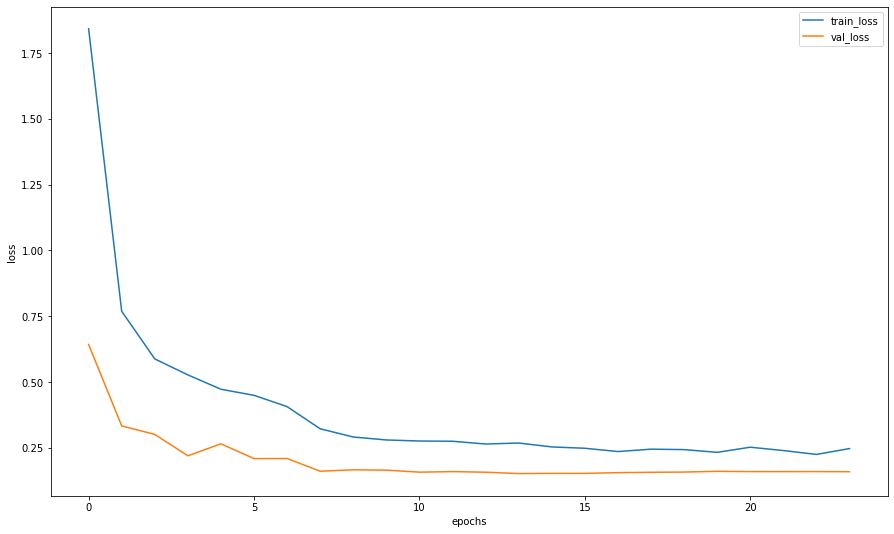

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
history, model_save_weights = train(train_dataset, val_dataset, model=model1, epochs=14, batch_size=64)

epoch:   0%|          | 0/14 [00:00<?, ?it/s]

loss 0.43943875616117223


epoch:   7%|▋         | 1/14 [09:11<1:59:26, 551.24s/it]


Epoch 001 train_loss: 0.4394     val_loss 0.1821 train_acc 0.8845 val_acc 0.9582
loss 0.40017694715891944


epoch:  14%|█▍        | 2/14 [18:24<1:50:21, 551.75s/it]


Epoch 002 train_loss: 0.4002     val_loss 0.2503 train_acc 0.8956 val_acc 0.9444
loss 0.3891910697743501


epoch:  21%|██▏       | 3/14 [27:35<1:41:07, 551.59s/it]


Epoch 003 train_loss: 0.3892     val_loss 0.2586 train_acc 0.8983 val_acc 0.9482
loss 0.3720764455017284


epoch:  29%|██▊       | 4/14 [36:46<1:31:54, 551.45s/it]


Epoch 004 train_loss: 0.3721     val_loss 0.2296 train_acc 0.9008 val_acc 0.9526
loss 0.3647642930339222


epoch:  36%|███▌      | 5/14 [45:58<1:22:44, 551.62s/it]


Epoch 005 train_loss: 0.3648     val_loss 0.2452 train_acc 0.9061 val_acc 0.9473
loss 0.34343790031100574


epoch:  43%|████▎     | 6/14 [55:08<1:13:27, 550.98s/it]


Epoch 006 train_loss: 0.3434     val_loss 0.1807 train_acc 0.9084 val_acc 0.9624
loss 0.34118360245111634


epoch:  50%|█████     | 7/14 [1:04:16<1:04:12, 550.37s/it]


Epoch 007 train_loss: 0.3412     val_loss 0.1908 train_acc 0.9112 val_acc 0.9580
loss 0.27646238588902955


epoch:  57%|█████▋    | 8/14 [1:13:24<54:57, 549.60s/it]


Epoch 008 train_loss: 0.2765     val_loss 0.1483 train_acc 0.9273 val_acc 0.9712
loss 0.25218961250858707


epoch:  64%|██████▍   | 9/14 [1:22:32<45:45, 549.10s/it]


Epoch 009 train_loss: 0.2522     val_loss 0.1439 train_acc 0.9314 val_acc 0.9715
loss 0.23651617626276994


epoch:  71%|███████▏  | 10/14 [1:31:39<36:33, 548.30s/it]


Epoch 010 train_loss: 0.2365     val_loss 0.1413 train_acc 0.9357 val_acc 0.9715
loss 0.22390389347905618


epoch:  79%|███████▊  | 11/14 [1:40:46<27:23, 547.88s/it]


Epoch 011 train_loss: 0.2239     val_loss 0.1472 train_acc 0.9382 val_acc 0.9738
loss 0.21948017343082385


epoch:  86%|████████▌ | 12/14 [1:49:53<18:15, 547.76s/it]


Epoch 012 train_loss: 0.2195     val_loss 0.1469 train_acc 0.9406 val_acc 0.9731
loss 0.2160506407395162


epoch:  93%|█████████▎| 13/14 [1:59:02<09:08, 548.18s/it]


Epoch 013 train_loss: 0.2161     val_loss 0.1495 train_acc 0.9415 val_acc 0.9710
loss 0.22179833520114844


epoch: 100%|██████████| 14/14 [2:08:10<00:00, 549.33s/it]


Epoch 014 train_loss: 0.2218     val_loss 0.1407 train_acc 0.9403 val_acc 0.9727


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [label_encoder.classes_[val_dataset[id][1]] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
# ПРиведенная выше модель должна была обучиться на 0.98 (она и показала на кегле 0.99),
# но я не зафидил ее, поэтому не смог повторить решение, модель выше все равно обучается 
# как минимум до 0.97, но если что я сохранил веса модели 0.98 и могу их скинуть, если необходимо
model_save_name = 'classifier-scedaug9820.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(modelsave.state_dict(), path)

In [ ]:
n_classes = len(np.unique(train_val_labels))
modelsave = models.vgg16().to(DEVICE)
modelsave.classifier[6] = nn.Linear(4096,n_classes).to(DEVICE)
model_save_name = 'classifier-scedaug1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
modelsave.load_state_dict(torch.load(path))

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(modelsave, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('gdrive/My Drive/simple_cnn_baseline2.csv', index=False)